## Activity 1 : Predicting HDB resale price
In this activity, we will learn:

*   HDB resale price dataset 
*   Load and preprocess the dataset
*   Split the dataset for training and testing
*   Define, compile and train a neural network model
*   Evaluate the model


### Resale Flat Prices
The Resale Flat Prices dataset can be downloaded at https://data.gov.sg/dataset/resale-flat-prices.  It contains the following data, month of the transaction, the town, flat type, block, street name, story range, floor area, flat model, lease commence date, remaining lease and Resale price. 

What we want to do is to train a neural network model that is able to predict the resale price of a particular HDB flat, given some information like town, lease commnce date and floor area for example.


### Mount Google Drive

Mount your Google Drive on your runtime using an authorization code.

Follow the instruction on the screen to authorise Colab accessing your drive. On your Google Drive, you can access you files prepend with “/content/drive/MyDrive/”

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import necessary libraries and dataset

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

### Process the dataset

If you download the dataset from data.gov.sg, unzip the files and use resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv.  At the time of this writing, the file contains about 94k transaction records.  We pandas to read the file into a dataframe. As you can see, we use a separate copy so we do not need to reload everytime we alter the dataframe

In [ ]:
file_url = "/content/drive/MyDrive/DATASETS/resale-flat-prices/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv"
data = pd.read_csv(file_url)
dataframe = data.copy()
dataframe.shape

(93818, 11)

Let us have a peek at the dataset

In [ ]:
dataframe.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


Let's do some cleaning up of the dataset

In [ ]:
#let's break date to years, months
dataframe['date'] = pd.to_datetime(dataframe['month'])
dataframe['month'] = dataframe['date'].apply(lambda date:date.month)
dataframe['year'] = dataframe['date'].apply(lambda date:date.year)

#Get number of years left on lease as a continuous number (ignoring months)
dataframe['remaining_lease'] = dataframe['remaining_lease'].apply(lambda remaining_lease:remaining_lease[:2])

#Get storey range as a continuous number
dataframe['storey_range'] = dataframe['storey_range'].apply(lambda storey_range:storey_range[:2])

In [ ]:
dataframe.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,date,year
0,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10,44.0,Improved,1979,61,232000.0,2017-01-01,2017
1,1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01,67.0,New Generation,1978,60,250000.0,2017-01-01,2017
2,1,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01,67.0,New Generation,1980,62,262000.0,2017-01-01,2017
3,1,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04,68.0,New Generation,1980,62,265000.0,2017-01-01,2017
4,1,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01,67.0,New Generation,1980,62,265000.0,2017-01-01,2017


**Geocoding**.  We would also like to geocode the addresses. However since geocoders usually have a limit to the amount of addresses we can geocode for free, I decided to geocode the towns only
We used Geopy and Geopanda as shown here https://towardsdatascience.com/geocode-with-python-161ec1e62b89

In [ ]:
#Concat address
dataframe['address'] = dataframe['block'].map(str) + ', ' + dataframe['street_name'].map(str) + ', Singapore' 
dataframe.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,date,year,address
0,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10,44.0,Improved,1979,61,232000.0,2017-01-01,2017,"406, ANG MO KIO AVE 10, Singapore"
1,1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01,67.0,New Generation,1978,60,250000.0,2017-01-01,2017,"108, ANG MO KIO AVE 4, Singapore"
2,1,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01,67.0,New Generation,1980,62,262000.0,2017-01-01,2017,"602, ANG MO KIO AVE 5, Singapore"
3,1,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04,68.0,New Generation,1980,62,265000.0,2017-01-01,2017,"465, ANG MO KIO AVE 10, Singapore"
4,1,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01,67.0,New Generation,1980,62,265000.0,2017-01-01,2017,"601, ANG MO KIO AVE 5, Singapore"


In [ ]:
!pip install geopandas 
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

     |████████████████████████████████| 1.0MB 14.0MB/s 
     |████████████████████████████████| 14.8MB 217kB/s 
     |████████████████████████████████| 6.5MB 58.5MB/s 


In [ ]:
#Geocode by town (Singapore is so small that geocoding by addresses might not make much difference compared to geocoding to town)

town = [x for x in dataframe['town'].unique().tolist() 
            if type(x) == str]
latitude = []
longitude =  []
for i in range(0, len(town)):
    # remove things that does not seem usefull here
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        loc = geolocator.geocode(town[i])
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
        print('The geographical coordinate of location are {}, {}.'.format(loc.latitude, loc.longitude))
    except:
        # in the case the geolocator does not work, then add nan element to list
        # to keep the right size
        latitude.append(np.nan)
        longitude.append(np.nan)
# create a dataframe with the locatio, latitude and longitude
df_ = pd.DataFrame({'town':town, 
                    'latitude': latitude,
                    'longitude':longitude})
# merge on Restaurant_Location with rest_df to get the column 
dataframe = dataframe.merge(df_, on='town', how='left')

The geographical coordinate of location are 1.3700803, 103.8495228.
The geographical coordinate of location are 1.3239765, 103.930216.
The geographical coordinate of location are 1.3509859, 103.84825507492937.
The geographical coordinate of location are 1.3490572, 103.7495906.
The geographical coordinate of location are 4.5616942, 101.0240366.
The geographical coordinate of location are 1.3791486, 103.76141301431002.
The geographical coordinate of location are 1.3546901, 103.7763724.
The geographical coordinate of location are 36.5070827, -79.7447575.
The geographical coordinate of location are 1.3847493, 103.7445341.
The geographical coordinate of location are 1.3151003, 103.7652311.
The geographical coordinate of location are 1.3181862, 103.8870563.
The geographical coordinate of location are 1.3708011, 103.89254433997465.
The geographical coordinate of location are 1.333108, 103.7422939.
The geographical coordinate of location are 1.3396365, 103.7073387.
The geographical coordinate 

In [ ]:
dataframe.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,date,year,address,latitude,longitude
0,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10,44.0,Improved,1979,61,232000.0,2017-01-01,2017,"406, ANG MO KIO AVE 10, Singapore",1.37008,103.849523
1,1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01,67.0,New Generation,1978,60,250000.0,2017-01-01,2017,"108, ANG MO KIO AVE 4, Singapore",1.37008,103.849523
2,1,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01,67.0,New Generation,1980,62,262000.0,2017-01-01,2017,"602, ANG MO KIO AVE 5, Singapore",1.37008,103.849523
3,1,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04,68.0,New Generation,1980,62,265000.0,2017-01-01,2017,"465, ANG MO KIO AVE 10, Singapore",1.37008,103.849523
4,1,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01,67.0,New Generation,1980,62,265000.0,2017-01-01,2017,"601, ANG MO KIO AVE 5, Singapore",1.37008,103.849523


Next we can drop some columns which is not useful for us.

In [ ]:
dataframe = dataframe.drop('date',axis=1)
dataframe = dataframe.drop('block',axis=1)
dataframe = dataframe.drop('lease_commence_date',axis=1)
dataframe = dataframe.drop('month',axis=1)
dataframe = dataframe.drop('street_name',axis=1)
dataframe = dataframe.drop('address',axis=1)
dataframe = dataframe.drop('year',axis=1)

In [ ]:
dataframe.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,resale_price,latitude,longitude
0,ANG MO KIO,2 ROOM,10,44.0,Improved,61,232000.0,1.37008,103.849523
1,ANG MO KIO,3 ROOM,01,67.0,New Generation,60,250000.0,1.37008,103.849523
2,ANG MO KIO,3 ROOM,01,67.0,New Generation,62,262000.0,1.37008,103.849523
3,ANG MO KIO,3 ROOM,04,68.0,New Generation,62,265000.0,1.37008,103.849523
4,ANG MO KIO,3 ROOM,01,67.0,New Generation,62,265000.0,1.37008,103.849523


As we can see from the above table, we are now down to 9 columns.  However, we are still not able to feed these data to train our neural network model.  We need to encode those categorial data, e.g. "2 ROOM" into a numercal representation so that it can be computed on.  To do this, we will use pandas's get_dummy() to perform a one-hot encoding on these columns.  In one-hot encoding, an array of labelled data (from Red, Yellow and Greem in the example below) is transformed into a vector shown below:


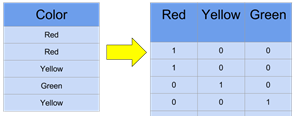

In [ ]:
df_2 = pd.get_dummies(dataframe, columns=['town','flat_type','storey_range','flat_model'])
df_2.head()

,floor_area_sqm,remaining_lease,resale_price,latitude,longitude,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,town_CHOA CHU KANG,town_CLEMENTI,town_GEYLANG,town_HOUGANG,town_JURONG EAST,town_JURONG WEST,town_KALLANG/WHAMPOA,town_MARINE PARADE,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN,flat_type_1 ROOM,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,storey_range_01,storey_range_04,storey_range_07,storey_range_10,storey_range_13,storey_range_16,storey_range_19,storey_range_22,storey_range_25,storey_range_28,storey_range_31,storey_range_34,storey_range_37,storey_range_40,storey_range_43,storey_range_46,storey_range_49,flat_model_2-room,flat_model_Adjoined flat,flat_model_Apartment,flat_model_DBSS,flat_model_Improved,flat_model_Improved-Maisonette,flat_model_Maisonette,flat_model_Model A,flat_model_Model A-Maisonette,flat_model_Model A2,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2
0,44.0,61,232000.0,1.37008,103.849523,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,67.0,60,250000.0,1.37008,103.849523,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,67.0,62,262000.0,1.37008,103.849523,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,68.0,62,265000.0,1.37008,103.849523,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,67.0,62,265000.0,1.37008,103.849523,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
len(df_2.columns)

75

We see that now we have expanded the number of columns to 75.  Of which 74 columns will be used as features to train our model.  Can you guess which column is not used as a feature?

That's right.  Remember, resale_price is our "target" (some call it label) that we are trying to predict, so this is not a feature.  The following will split the dataset into features and traget. We typically pre-fix the features array with a "X" and the target array with a "y".

In [ ]:
X = df_2.drop('resale_price',axis =1)
y = df_2['resale_price']
X=X.values
y=y.values

Next we will split the dataset such that 30% is used for evaluating the model and 70% is used for training the model.

In [ ]:
#splitting Train and Test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
# Let us print the first element in the array to have a look at the data
print(X_train[0])

[123.0 '76' 1.3708011 103.89254433997465 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Next, we will use a MinMax scaler to transform the dataset. This scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.  Many machine learning algorithms perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed. 

In [ ]:
#MinMax scaler - fit&transform on train, fit only on test
s_scaler = MinMaxScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float))


Let us take a look at the transformed data

In [ ]:
print(X_train[0])

[0.44660194 0.60377358 0.56908764 0.75481882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


### Create the network

Now we are ready to define our neural network.

For this demo, just run the code block to get familiar.  We will discuss the details of creating neural network in the next few activities.


In [ ]:
# Creating a Neural Network Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.optimizers import Adam
# having 74 neuron is based on the number of available features
model = Sequential()
model.add(Dense(100,activation='relu',input_shape=(74,)))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam',loss='mse',metrics=['mse',"mae"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               7500      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               1

### Train the network

Now we’re ready to train the model. Keras models its syntax on scikit-learn, so its training function is also called fit().

In [ ]:
%%time
history=model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,epochs=100)

Epoch 1/100
514/514 [==============================] - 6s 5ms/step - loss: 53843587889.2116 - mse: 53843587889.2116 - mae: 145855.6898 - val_loss: 2743405824.0000 - val_mse: 2743405824.0000 - val_mae: 38191.0469
Epoch 2/100
514/514 [==============================] - 2s 4ms/step - loss: 2654447808.8699 - mse: 2654447808.8699 - mae: 38234.5324 - val_loss: 2307480832.0000 - val_mse: 2307480832.0000 - val_mae: 35530.9766
Epoch 3/100
514/514 [==============================] - 2s 4ms/step - loss: 2378977765.4058 - mse: 2378977765.4058 - mae: 36095.4023 - val_loss: 2229691392.0000 - val_mse: 2229691392.0000 - val_mae: 34681.0312
Epoch 4/100
514/514 [==============================] - 2s 4ms/step - loss: 2268387912.3262 - mse: 2268387912.3262 - mae: 35117.5637 - val_loss: 2146635008.0000 - val_mse: 2146635008.0000 - val_mae: 34061.1094
Epoch 5/100
514/514 [==============================] - 2s 4ms/step - loss: 2249843925.4990 - mse: 2249843925.4990 - mae: 34946.9450 - val_loss: 2426963200.0000 -

### Evaluate the network

After training, we can call the **evaluate()** function to have a feel of how our model perform

In [ ]:
model.evaluate(X_test,y_test)

880/880 [==============================] - 2s 2ms/step - loss: 1647243648.0000 - mse: 1647243648.0000 - mae: 29245.5801


[1647243648.0, 1647243648.0, 29245.580078125]

We see that our model achieved a modest Mean Absolute Error of 29245.  Let's continue to have a look at the training curve

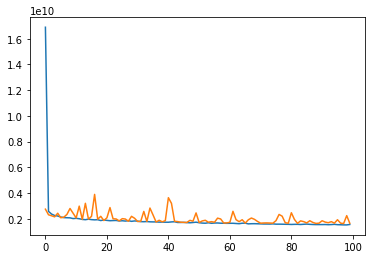

In [ ]:
# plot metrics
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

Finally, let us compare the prediction made on the test dataset

In [ ]:
y_pred = model.predict(X_test)
y_pred_2 = []
for pred in y_pred:
  y_pred_2.append(pred[0])

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_2})
df1 = df.head(20)
df1

,Actual,Predicted
0,475000.0,456141.437500
1,345000.0,332299.812500
2,413000.0,472349.625000
3,310000.0,341883.531250
4,310000.0,297812.031250
5,653000.0,668083.250000
6,480000.0,463512.687500
7,640000.0,573179.625000
8,400000.0,363254.406250
9,350000.0,342406.781250
